# timeframe: 2011-02-21 to 2018-09-09

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import spacy
from textblob import TextBlob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import words
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, MWETokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, MeanShift

from sklearn import metrics

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import joblib
pd.options.display.colheader_justify = 'right'
pd.options.display.column_space = 1
pd.options.display.expand_frame_repr = True
pd.options.display.max_colwidth = 120

In [38]:
df = joblib.load('data/clean/clean_df.joblib')
df = df.loc[df.body != 'full quote', :] # drop the 'full quote' only comment

In [3]:
# don't use stemming with Word2Vec

In [4]:
# TODO: Properly do entire data set and a train_test_split later on
df_small = df.sample(30000, random_state=0)

df_small_train = df_small[:int(0.7 * df_small.shape[0])]
df_small_test = df_small[int(0.7 * df_small.shape[0]):]

# TF

### Next steps:
1. I want to find the X topics/clusters about these texts. Perhaps it's fitness, politics, training, performance, GOAT.
2. Figure out which topic each document best corresponds to, and place the document within that topic/cluster
3. Chart a stacked-bar or a multi-line chart for each year (or month, or something else) from 2011-2018, and show
   the PERCENTAGE (Or COUNT) of each topic for that period of time.
4. Look at the insights! What does that mean?
5. Perhaps do sentiment analysis. See if I can find a well-trained model. Or train my own based on upvote? score? (Probably not doing this)

**NOTE**: Simply do LDA first, and make this work. Get a chart. Get some insights.
**THEN:** Make it repeatable. Get it in a function somehow. Try other Dim Red and Unclassifying and Topic modeling techniques. See what works best.

In [39]:
def see_lda_topics(vectorizer, n_topics, fit_lda, n_examples):
    '''
    Prints top 10 names assigned to the topics, and the topics themselves
    '''
    vocab = vectorizer.get_feature_names()
    for topic in range(n_topics):
        print(f"TOPIC {topic}")
        for j in np.argsort(-fit_lda.components_,1)[topic,:n_examples]:
            print(vocab[j])
        print()

In [84]:
words_corpus = set(words.words())
analyzer = CountVectorizer().build_analyzer()
stem = SnowballStemmer('english')

stops = stopwords.words('english')
stops += ['lebron', 'james', 'game', 'us', 'need', 'let', 'well', 'year', 'dude', 'could', 'couldnt',
          'gon', 'gonna', 'na', 'ca', 'really', 'man', 'much',# 'last', 'next', 'one',
          'just', 'lol', 'like', 'im', 'he', 'hes', 'would', 'get', 'going', 'got', 'every',
          'doesnt', 'th', 'fuck', 'think', 'even', 'dont', 'even', 'pretty', 'really',
          'didnt', 'cant', 'say', 'see', 'look', 'go', 'said', 'also', 'still', 'good'
         ]
stops = set(stops)
acceptable_words = words_corpus - stops

# create a custom vectorizer class that inherits from base class
# add a few more custom preprocessing and tokenization steps
class CustomVectorizer(CountVectorizer):  
    def build_analyzer(self):
        stop_words = stops
        
        def analyzer(doc):
            
            # preprocess: do any further cleaning here if needed
            # example: remove everything but letters
#             cleaned_doc = re.sub(r"[^A-Za-z]", " ", doc)
            cleaned_doc = doc
    
            # instantiate snowball stemmer
            stemmer = SnowballStemmer("english")
            # create tokens
            tokens = [stemmer.stem(d) for d in word_tokenize(cleaned_doc) if d in acceptable_words] 
            
            # multi-word expression tokenizer
            tokenizer = MWETokenizer()
            tokenizer.add_mwe(('k', 'love'))
            tokenizer.add_mwe(('kevin', 'love'))
            tokenizer.add_mwe(('dwayne', 'wade'))
            tokenizer.add_mwe(('d', 'wade'))
            tokenizer.add_mwe(('jr', 'smith'))
            tokenizer.add_mwe(('j', 'r', 'smith'))
            tokenizer.add_mwe(('j', 'r'))
            # tokenize the tokens
            tokens = tokenizer.tokenize(tokens)
            
            return(self._word_ngrams(tokens, stop_words))
        return analyzer

In [50]:
# def english_corpus(doc, stemmer=stem):
#     clean_words = [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]   
#     return [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]

Current isues:
* can't use stemmer and n_grams at same time.
* still too many junk words, even with growing stop_list
* **don't have a lemmatizer in there. How can i do lemmatize, n_grams, stop words, and stemmer all in analyer?**

In [51]:
# BI GRAMS

In [52]:
# cVectorizer = CustomVectorizer(# strip_accents='ascii',
#                                max_df=0.70,
#                                min_df=4,
#                                stop_words = stops,
#                                ngram_range=(2,2)
#                               )

# dtm_tf_custom = cVectorizer.fit_transform(df_small_train.body)
# #dtm_tf_custom.shape

# for n_topic in range(4,10):
#     loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
#     loop_lda_tf.fit(dtm_tf_custom)
#     print(':::::')
#     print(f'Number of topics = {n_topic}')
#     print(':::::')
#     see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 10)

In [53]:
# MOSTLY UNI GRAMS. ALLOWS BI AND TRI GRAMS

In [67]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.7,
                               min_df=4,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df.body)
#dtm_tf_custom.shape

for n_topic in range(7,10):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0, n_jobs=-1)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 15)

:::::
Number of topics = 7
:::::
TOPIC 0
one
season
better
player
best
leagu
point
ever
shoot
year
curri
make
per
defens
time

TOPIC 1
love
time
year
play
great
coach
defens
day
one
mani
last
actual
feel
post
back

TOPIC 2
win
team
could
top
basketbal
right
time
peopl
goat
take
player
make
last
probabl
one

TOPIC 3
team
play
pick
pass
best
take
player
anyon
way
better
bad
someon
els
big
everyon

TOPIC 4
wade
peopl
guy
come
heat
want
talk
new
know
confirm
give
nice
fan
team
hate

TOPIC 5
team
year
back
first
win
season
know
one
best
come
tripl
doubl
next
trade
make

TOPIC 6
watch
damn
dude
ball
high
play
jordan
call
know
actual
time
never
k
great
foul

:::::
Number of topics = 8
:::::
TOPIC 0
one
player
best
leagu
make
ever
shoot
season
point
seen
better
defens
curri
team
time

TOPIC 1
love
time
great
year
play
coach
defens
actual
day
one
post
way
lue
last
feel

TOPIC 2
win
basketbal
top
right
could
time
team
peopl
goat
take
player
make
beat
probabl
last

TOPIC 3
best
team
play
player
p

In [55]:
# BI and TRI-GRAMS

In [68]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.9,
                               min_df=2,
                               stop_words = stops,
                               ngram_range=(2,4)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df_small.body)
#dtm_tf_custom.shape

for n_topic in range(2,6):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0, n_jobs=-1)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 15)

:::::
Number of topics = 2
:::::
TOPIC 0
last year
high school
tripl doubl
ever seen
regular season
next year
golden state
eastern confer
first round
dan gilbert
free throw
never seen
best ever
win championship
last season

TOPIC 1
best player
regular season
year old
player leagu
come back
best player leagu
god damn
one best
basketbal player
player world
wade bosh
last year
locker room
first time
watch play

:::::
Number of topics = 3
:::::
TOPIC 0
high school
ever seen
last year
eastern confer
one time
anyon els
derrick rose
point guard
never seen
win championship
top player
come back
role model
best ever
space jam

TOPIC 1
best player
player leagu
come back
best player leagu
locker room
year old
god damn
wade bosh
first time
make sure
big deal
back back
player world
three point
player team

TOPIC 2
last year
tripl doubl
regular season
next year
year old
basketbal player
one best
best player
golden state
free throw
dan gilbert
last season
player ever
everyon els
first round

:::::
Num

# Run chosen LDA model, cluster, then plot

In [4]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.7,
                               min_df=4,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df.body)
#dtm_tf_custom.shape

lda = LatentDirichletAllocation(n_components=9, random_state=0, n_jobs=-1)
#loop_lda_tf.fit(dtm_tf_custom)

transformed_lda = lda.fit_transform(dtm_tf_custom)

In [71]:
pyLDAvis.sklearn.prepare(lda, dtm_tf_custom, cVectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.135299  0.041656       1        1  14.107050
2      0.027982 -0.015418       2        1  11.789902
3      0.033736  0.063955       3        1  11.603419
6     -0.073032  0.108014       4        1  11.281074
5      0.118416 -0.050655       5        1  10.775733
1     -0.080613  0.050426       6        1  10.543028
8     -0.109077  0.114184       7        1  10.400451
7      0.142663 -0.112248       8        1  10.340898
4     -0.195375 -0.199914       9        1   9.158446, topic_info=      Category         Freq       Term        Total  loglift  logprob
term                                                                 
11783  Default  2175.000000       year  2175.000000  30.0000  30.0000
1004   Default  1797.000000       best  1797.000000  29.0000  29.0000
8610   Default  1818.000000     season  1818.000000  28.0000  28.0000
1107   Default  1621.000000     better  1621.000000  27.0000  27.0000
2363   Default   835.000000       damn   835.000000  26.0000  26.0000
11246  Default  1204.000000      watch  1204.000000  25.0000  25.0000
5682   Default  1726.000000       love  1726.000000  24.0000  24.0000
6713   Default  3187.000000        one  3187.000000  23.0000  23.0000
11093  Default  1035.000000       wade  1035.000000  22.0000  22.0000
9911   Default  3042.000000       team  3042.000000  21.0000  21.0000
10580  Default   830.000000        top   830.000000  20.0000  20.0000
3574   Default  1287.000000      first  1287.000000  19.0000  19.0000
633    Default  1605.000000       back  1605.000000  18.0000  18.0000
7298   Default   535.000000       pick   535.000000  17.0000  17.0000
7451   Default  2170.000000     player  2170.000000  16.0000  16.0000
6492   Default   847.000000       next   847.000000  15.0000  15.0000
2501   Default   995.000000     defens   995.000000  14.0000  14.0000
2831   Default   681.000000       dude   681.000000  13.0000  13.0000
4003   Default   472.000000       goat   472.000000  12.0000  12.0000
11524  Default  1497.000000        win  1497.000000  11.0000  11.0000
7346   Default  1759.000000       play  1759.000000  10.0000  10.0000
848    Default  1060.000000  basketbal  1060.000000   9.0000   9.0000
8932   Default   797.000000       shot   797.000000   8.0000   8.0000
1810   Default   550.000000      coach   550.000000   7.0000   7.0000
3172   Default  1191.000000       ever  1191.000000   6.0000   6.0000
5274   Default  1266.000000       last  1266.000000   5.0000   5.0000
5053   Default   365.000000          k   365.000000   4.0000   4.0000
4968   Default  1101.000000     jordan  1101.000000   3.0000   3.0000
10358  Default  2801.000000       time  2801.000000   2.0000   2.0000
2758   Default   409.000000      doubl   409.000000   1.0000   1.0000
...        ...          ...        ...          ...      ...      ...
11093   Topic9   628.894065       wade  1035.220216   1.8921  -3.9536
4522    Topic9   131.388284        hey   176.523145   2.0952  -5.5194
4947    Topic9    98.712201     jersey   128.593658   2.1260  -5.8053
6521    Topic9   233.040145       nice   367.054591   1.9362  -4.9463
5112    Topic9   184.642264       king   285.442330   1.9549  -5.1791
10127   Topic9   240.569192       tell   419.956594   1.8334  -4.9145
1494    Topic9    84.202709          c   111.277690   2.1117  -5.9643
10564   Topic9   197.194936    tonight   338.581360   1.8499  -5.1133
6487    Topic9   118.968659       news   175.492620   2.0018  -5.6187
9858    Topic9   351.638147       talk   746.526591   1.6377  -4.5349
6270    Topic9   171.737879      money   299.682206   1.8337  -5.2515
11187   Topic9   391.039069       want   940.221166   1.5132  -4.4287
8000    Topic9   214.062773          r   429.935625   1.6931  -5.0312
5067    Topic9   204.988044       keep   446.306904   1.6124  -5.0746
1854    Topic9   381.676903       come  1210.271092   1.2365  -4.4529
422

In [202]:
# cossim = cosine_similarity(transformed_lda[:1000]) USE THIS ONE
#eucdist = euclidean_distances(transformed_lda[:20000])

# # generate cosine_similarity and euclidian distance scores. They seem quite similar. For now i'll choose cosine similarity
# print(df.body.iloc[6])
# print(df.body.iloc[7])
# print(cossim[6,7])
# print(eucdist[6,7])

# Use Clustering Algo to group documents into X num_topics by most similar topics

In [ ]:
# PICK A CLUSTERING ALGO THAT USES COSINE SIMILARITY
### PERHAPS DBSCAN
##### create clusters (start with a small number, cluster_num DOES NOT need to equal the number of topics)

#----------- Chad recommended this:
# plot by argmax (basically saying which topic is most dominant in each document)
# plot by a groupby(time) and then mean the values of each topic. so then i'll have "documents for jan 2011 have [t1, t2, t3, t4, t5] and plot that.
# look into a hard clusting like Kmeans (right now, let's put this behind us)

In [7]:
del(words, stops, acceptable_words, lda, dtm_tf_custom, analyzer, stem)

In [8]:
transformed_lda.shape

(45671, 9)

In [9]:
#ag = AgglomerativeClustering(n_clusters=2, affinity='cosine'

db = None
db = DBSCAN(eps=0.01, min_samples=25, metric='cosine', leaf_size=10, n_jobs=-1).fit(transformed_lda)

labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

unique, counts = np.unique(labels, return_counts=True)
print('counts')
print(np.asarray((unique, counts)).T)

Estimated number of clusters: 2
counts
[[   -1  6116]
 [    0 36081]
 [    1  3474]]


In [17]:
transformed_lda[:2]

array([[0.02224433, 0.02223958, 0.02223336, 0.02224224, 0.41372898,
        0.02222621, 0.02224352, 0.02226324, 0.43057854],
       [0.41177836, 0.00926471, 0.00927027, 0.00926946, 0.00926638,
        0.00926359, 0.00926079, 0.52335907, 0.00926736]])

In [15]:
db.components_

array([[0.02224433, 0.02223958, 0.02223336, ..., 0.02224352, 0.02226324,
        0.43057854],
       [0.41177836, 0.00926471, 0.00927027, ..., 0.00926079, 0.52335907,
        0.00926736],
       [0.01010265, 0.01011197, 0.91914987, ..., 0.01010447, 0.01010568,
        0.0101056 ],
       ...,
       [0.40600085, 0.01853718, 0.01852288, ..., 0.01852027, 0.46432564,
        0.01852079],
       [0.02780547, 0.02783899, 0.02782247, ..., 0.02780109, 0.02779019,
        0.44065516],
       [0.53423209, 0.27122796, 0.02779924, ..., 0.02778024, 0.02778609,
        0.02779939]])

In [27]:
DBdf.sample(50)

,0,1,2,3,4,5,6,7,8,cluster,created_utc
37177,0.018534,0.018530,0.018523,0.018534,0.018526,0.018539,0.298611,0.018519,0.571685,0,2017-02-13 21:27:48
12271,0.055556,0.055556,0.555556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0,2018-04-26 01:45:29
31435,0.022234,0.629159,0.022233,0.022222,0.022222,0.022233,0.215233,0.022235,0.022228,0,2017-07-26 01:04:59
16565,0.055562,0.055576,0.555363,0.055589,0.055601,0.055556,0.055589,0.055562,0.055602,0,2016-02-06 03:45:06
38873,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,2017-10-25 16:50:56
25335,0.013893,0.013893,0.013890,0.013892,0.013895,0.153864,0.013890,0.748886,0.013895,0,2016-08-04 20:00:34
30312,0.018527,0.018528,0.018535,0.018524,0.018528,0.018529,0.851783,0.018526,0.018520,0,2017-08-27 00:58:28
4326,0.006544,0.006544,0.006540,0.006538,0.006550,0.006537,0.006541,0.947670,0.006537,0,2014-06-09 06:09:44
10530,0.007409,0.007414,0.007412,0.402337,0.091652,0.007410,0.007410,0.461547,0.007410,0,2017-12-23 00:26:09
29734,0.018523,0.578039,0.018525,0.018527,0.018526,0.292274,0.018530,0.018532,0.018524,0,2017-09-19 21:37:19


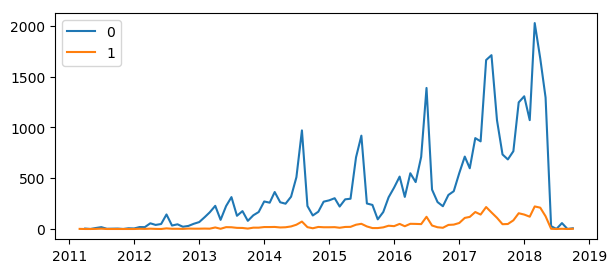

In [20]:
DBdf = pd.DataFrame(db.components_, index=db.core_sample_indices_, copy=True)
df2 = df.reset_index()
DBdf['cluster'] = pd.Series(db.labels_)
DBdf['created_utc'] = df2['created_utc']

# write function that slices on label, and plots what you want.
def cluster_count_by_time(df, cluster_col, time_col, time_chunk, drop_biggest_cluster=False):
    df = df.loc[:, [cluster_col, time_col]]    
    plt.figure(figsize=(7,3), dpi=100)
    
#     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
#     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
#     plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
    
    if not drop_biggest_cluster:
        num_clusters = range(len(df[cluster_col].unique()))
    else:
        num_clusters = range(1, len(df[cluster_col].unique()))
        
    for i in num_clusters:
        # slice DF to that label
        dfZ = df[df[cluster_col] == i]
        
        # group everything by year/time
        dfZ = dfZ.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count().reset_index()
        
        # plot dataframe
#         dfZ.plot(x=time_col, y=cluster_col, figsize=(12,8))
        plt.plot(dfZ[time_col], dfZ[cluster_col])
    plt.legend(labels=num_clusters)
    plt.show();
cluster_count_by_time(DBdf, cluster_col='cluster', time_col='created_utc', time_chunk='M', drop_biggest_cluster=False)

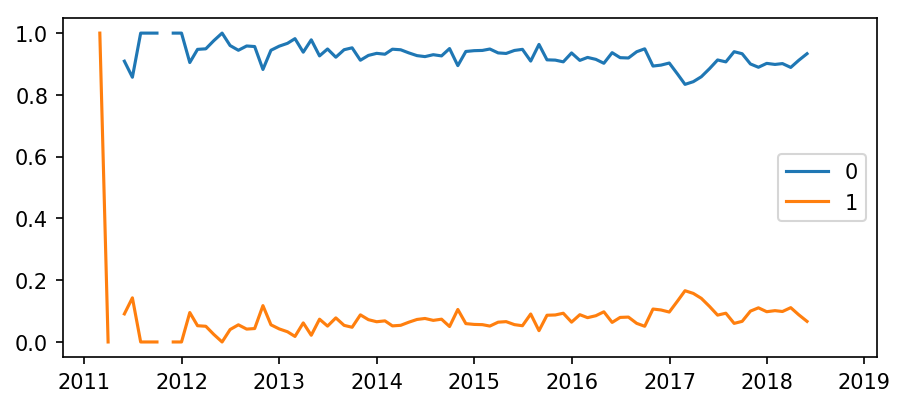

In [19]:
db_norm_df = pd.DataFrame(db.components_, index=db.core_sample_indices_, copy=True)
df2 = df.reset_index()
db_norm_df['cluster'] = pd.Series(db.labels_)
db_norm_df['created_utc'] = df2['created_utc']
db_norm_df = db_norm_df[['cluster', 'created_utc']]
def cluster_norm_by_time(df, cluster_col, time_col, time_chunk, drop_biggest_cluster=False):
    df = df.loc[:, [cluster_col, time_col]]    
    plt.figure(figsize=(7,3), dpi=150)

    if not drop_biggest_cluster:
        num_clusters = range(len(df[cluster_col].unique()))
    else:
        num_clusters = range(1, len(df[cluster_col].unique()))
    
    for i in num_clusters:
        # create df with count of all labels by the time_chunk grouping
        df_master = df.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count()
        df_master.rename(columns={cluster_col:'count_of_all_labels'}, inplace=True)
        
        # create df with count of only INTERESTED cluster label by time_chunk grouping
        dfX = df[df[cluster_col] == i]
        
        # slice df to that ratio
        dfZ = dfX.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count()
        dfZ.rename(columns={time_chunk:'count_of_interest_label'}, inplace=True)
        
        # add column to master one (dfA)
        df_master['count_of_interest_only'] = dfZ
        
        #make ratio column
        df_master['ratio'] = df_master.count_of_interest_only / df_master.count_of_all_labels
        
        df_master = df_master.reset_index()
        # plot dataframe
#         dfZ.plot(x=time_col, y=cluster_col, figsize=(12,8))
        plt.plot(df_master[time_col], df_master['ratio'])
    plt.legend(labels=num_clusters)
    plt.show();
cluster_norm_by_time(db_norm_df, cluster_col='cluster', time_col='created_utc', time_chunk='M', drop_biggest_cluster=False)

AttributeError: 'function' object has no attribute 'df_master'

In [74]:
'cat'[:5]

'cat'

# Test NMF and Display topics better

In [85]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx}")
        print("TOP WORDS:", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort(W[:,topic_idx])[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print("DOC:", documents[doc_index][:100])

dataset = df.reset_index()
documents = dataset.body

no_features = 700

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, ngram_range=(1,3), stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.95,
                               min_df=2,
                               stop_words = stops,
                               max_features=no_features,
                               ngram_range=(1,3)
                              )
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [86]:
no_topics = 30

for no_topics in range(18, 33, 3):

    # Run NMF
    nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    nmf_W = nmf_model.transform(tfidf)
    nmf_H = nmf_model.components_

    # Run LDA
    lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    lda_W = lda_model.transform(tf)
    lda_H = lda_model.components_

    no_top_words = 14
    no_top_documents = 5
    print("")
    print(f"{no_topics} TOPICS for TF-IDF and NMF RESULTS")
    print("")
    display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)
    print("")
    print(f"{no_topics} TOPICS for LDA and DTM RESULTS")
    print("")
    display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)


18 TOPICS for TF-IDF and NMF RESULTS

Topic 0
TOP WORDS: play people never years great way wade make players ball point first take guys
DOC: i'm not going to make a case for who is better but i do have some advice for nba fans pretend that l
DOC: the people in here trying to make the argument that lebron has always been on stacked teams and only
DOC: i know people will rapidly make jokes about the title as it looks like it's only that but the articl
DOC: i still stand by this the whole discussion is stupid and a media fraud anyway basketball is a team g
DOC: i feel like everyone is buying up kd's excuses for what it is oh yea of course people change what he
Topic 1
TOP WORDS: one ever one best day greatest another seen favorite things win history others person ever seen
DOC: i like the one dez bryant did
DOC: van gundy should be the one that meets with silver
DOC: jimmy butler has one of the most inspiring stories
DOC: this one is pretty weak
DOC: even more surprising hedo turkoglu wo

In [ ]:
font = {'fontname':'Carlito',
             'size': 16}
    
    tickfont = {'fontname':'Carlito',
             'size': 16}
    
    titlefont = {'fontname':'Carlito',
             'size': 28}
    
#     fpr1, tpr1, _ = roc_curve(y_test, y_score_main)
# #     fpr2, tpr2, _ = roc_curve(y_test2, y_score_second)
#     plt.clf()
#     plt.figure(figsize = (8,8), dpi=300)
#     plt.xlim(xmin=0, xmax=1)
#     plt.ylim(ymin=0, ymax=1.001)
# #     plt.f
# #     plt.figlegend(
#     plt.figtext(.55, .35,'GB  AUC  =  .774',bbox=dict(facecolor='#FA3B66', alpha=0.8), **titlefont)
# #     plt.figtext(.55, .30,"GB  AUC  =  .806",bbox=dict(facecolor='#2274a5', alpha=0.5), **titlefont)

#     #Plot the baseline
#     plt.plot([0,1],[0,1], c='#ccced2', ls='--')
#     plt.plot(fpr1, tpr1, c='#FA3B66', linewidth=2.5, alpha = 0.8)
# #     plt.plot(fpr2, tpr2, c='#2274a5', linewidth=2)
#     plt.title('ROC Curve', **titlefont)
#     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
#     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
#     plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.grid(b=True, which='major', axis='both', alpha=0.2)
#     plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
#     plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
#     sns.despine(ax=plt.gca())

In [222]:
# # Save to do a hard-clustering algo like kmeans for later
# transformed_lda[0]
# transformed_lda[1]
# transformed_lda.argmax(axis=1)
# km = KMeans(n_clusters=5, init='k-means++', random_state=0, n_jobs=-1)
# topic_split = km.fit_transform(transformed_lda)
# topic_split[0]
# topic_split[2]
# topic_split.shape

In [65]:
pd.DataFrame(dtm_tf_custom.toarray(), columns=cVectorizer.get_feature_names()).shape

lda_tf = LatentDirichletAllocation(n_components=15, random_state=0)
lda_tf.fit(dtm_tf_custom)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf_custom, cVectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.050456  0.068146       1        1  12.343966
6     -0.015559  0.076990       2        1   8.541368
9      0.015332  0.020617       3        1   7.716463
0     -0.086664 -0.041103       4        1   6.896758
11     0.097437  0.032138       5        1   6.744538
8      0.061580  0.017532       6        1   6.402759
1     -0.060601  0.001668       7        1   6.174580
7      0.122422  0.037775       8        1   6.080679
10    -0.030208  0.082661       9        1   6.030568
12     0.100708  0.081865      10        1   6.006607
14    -0.059938 -0.175645      11        1   5.881264
4     -0.145948  0.054876      12        1   5.717746
2     -0.161351 -0.031329      13        1   5.441466
13     0.122482 -0.024180      14        1   5.425373
3      0.090765 -0.202013      15        1   4.595865, topic_info=      Category         Freq      Term        Total  loglift  logprob
term                                                                
12406  Default  1374.000000      year  1374.000000  30.0000  30.0000
9102   Default  1149.000000    season  1149.000000  29.0000  29.0000
10514  Default  1931.000000      team  1931.000000  28.0000  28.0000
7060   Default  2025.000000       one  2025.000000  27.0000  27.0000
4108   Default  1102.000000       got  1102.000000  26.0000  26.0000
4504   Default   426.000000    harden   426.000000  25.0000  25.0000
11653  Default   642.000000      wade   642.000000  24.0000  24.0000
3991   Default  1278.000000      good  1278.000000  23.0000  23.0000
12148  Default  1014.000000       win  1014.000000  22.0000  22.0000
11804  Default   785.000000     watch   785.000000  21.0000  21.0000
1040   Default  1035.000000    better  1035.000000  20.0000  20.0000
7785   Default  1393.000000    player  1393.000000  19.0000  19.0000
2684   Default   263.000000     doubl   263.000000  18.0000  18.0000
9240   Default   340.000000      seen   340.000000  17.0000  17.0000
7547   Default   305.000000       per   305.000000  16.0000  16.0000
619    Default  1041.000000      back  1041.000000  15.0000  15.0000
11140  Default   552.000000       top   552.000000  14.0000  14.0000
3945   Default   322.000000      goat   322.000000  13.0000  13.0000
4668   Default   434.000000      high   434.000000  12.0000  12.0000
10014  Default  1136.000000     still  1136.000000  11.0000  11.0000
2228   Default   440.000000     curri   440.000000  10.0000  10.0000
4216   Default   944.000000     great   944.000000   9.0000   9.0000
5114   Default   733.000000    jordan   733.000000   8.0000   8.0000
1286   Default   282.000000      bosh   282.000000   7.0000   7.0000
11304  Default   214.000000     tripl   214.000000   6.0000   6.0000
3535   Default   810.000000     first   810.000000   5.0000   5.0000
1737   Default   395.000000     coach   395.000000   4.0000   4.0000
8658   Default   204.000000   regular   204.000000   3.0000   3.0000
3083   Default   773.000000      ever   773.000000   2.0000   2.0000
10931  Default  1854.000000      time  1854.000000   1.0000   1.0000
...        ...          ...       ...          ...      ...      ...
1299   Topic15    68.968201    boston   120.344042   2.5233  -5.1226
6415   Topic15    71.901881      mike   128.300567   2.5009  -5.0810
883    Topic15   110.438995      beat   255.905815   2.2397  -4.6518
1401   Topic15    25.148227      burn    34.674733   2.7588  -6.1315
9976   Topic15    76.028340      stay   176.609502   2.2372  -5.0252
8422   Topic15    51.753893       ray   100.993175   2.4115  -5.4098
11708  Topic15    92.076144      wait   286.866408   1.9436  -4.8337
6653   Topic15    59.716004      name   146.620901   2.1818  -5.2667
11098  Topic15    68.901883     today   198.414388   2.0223  -5.1236
11744  Topic15   115.385070      want   606.731262   1.4202  -4.6080
4425   Topic15    32.509028    hakeem    56.630656   2.5250  -5.8748
113

In [33]:
cv = CountVectorizer(stop_words=stops, 
                     #analyzer=english_corpus,
                     analyzer=analyzer,
                     min_df = 3, max_df = .95, ngram_range=(1, 2),
                     strip_accents='unicode', 
                     encoding='utf-8',
                     # tokenizer=TreebankWordTokenizer().tokenize,
                     #max_features=100
                    )

In [33]:
dtm_tf = cv.fit_transform(df_small_train.body)
dtm_tf.shape

(14000, 5298)

# LDA

In [34]:
pd.DataFrame(dtm_tf.toarray(), columns=cv.get_feature_names()).shape

lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, cv)

KeyboardInterrupt: 

# TF-IDF

In [71]:
cv2 = CountVectorizer(#stop_words=stops, 
                     analyzer=english_corpus, 
                     min_df = 2, max_df = .95, #ngram_range=(1, 2),
                     strip_accents='unicode', encoding='utf-8')

tfidf_vectorizer = TfidfVectorizer(**cv2.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_small_train.body)

lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.051493 -0.005656       1        1  17.891667
7     -0.068342  0.014101       2        1  13.069484
5     -0.035743 -0.013699       3        1   9.888963
4     -0.070377 -0.058975       4        1   9.431428
1     -0.082874 -0.050363       5        1   9.166373
6      0.089967  0.041093       6        1   8.382241
3     -0.002557  0.129411       7        1   8.372704
2      0.082768  0.092074       8        1   8.316884
9     -0.001495 -0.011377       9        1   8.013487
8      0.140146 -0.136609      10        1   7.466769, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1510  Default  34.000000      nice  34.000000  30.0000  30.0000
491   Default  33.000000   confirm  33.000000  29.0000  29.0000
593   Default  46.000000      damn  46.000000  28.0000  28.0000
696   Default  22.000000     doubl  22.000000  27.0000  27.0000
1261  Default  20.000000      king  20.000000  26.0000  26.0000
1458  Default  18.000000      miss  18.000000  25.0000  25.0000
1390  Default  65.000000       man  65.000000  24.0000  24.0000
2403  Default  16.000000     tripl  16.000000  23.0000  23.0000
1382  Default  24.000000     magic  24.000000  22.0000  22.0000
1897  Default  42.000000     right  42.000000  21.0000  21.0000
1552  Default  20.000000        oh  20.000000  20.0000  20.0000
1010  Default  26.000000       god  26.000000  19.0000  19.0000
2331  Default  14.000000       tho  14.000000  18.0000  18.0000
1367  Default  65.000000      love  65.000000  17.0000  17.0000
1446  Default  15.000000   million  15.000000  16.0000  16.0000
1985  Default  54.000000    season  54.000000  15.0000  15.0000
1781  Default  18.000000  question  18.000000  14.0000  14.0000
1842  Default  15.000000   regular  15.000000  13.0000  13.0000
1045  Default  43.000000       guy  43.000000  12.0000  12.0000
2382  Default  15.000000     trade  15.000000  11.0000  11.0000
445   Default  25.000000     coach  25.000000  10.0000  10.0000
1614  Default  27.000000      pass  27.000000   9.0000   9.0000
1830  Default  14.000000    record  14.000000   8.0000   8.0000
1875  Default  16.000000   respect  16.000000   7.0000   7.0000
336   Default  28.000000      call  28.000000   6.0000   6.0000
1415  Default  24.000000      mean  24.000000   5.0000   5.0000
103   Default  23.000000     anyon  23.000000   4.0000   4.0000
1278  Default  17.000000      lanc  17.000000   3.0000   3.0000
2358  Default  15.000000     today  15.000000   2.0000   2.0000
28    Default  11.000000        ad  11.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
136   Topic10   1.836326  assassin   2.601165   2.2465  -6.4022
1401  Topic10   1.772000    martin   2.536830   2.2359  -6.4379
1462  Topic10   2.239007        mo   3.221734   2.2308  -6.2040
1515  Topic10   6.359971    nobodi   9.640802   2.1787  -5.1600
1875  Topic10  10.100956   respect  16.101310   2.1284  -4.6974
2550  Topic10   5.587835      west   8.584732   2.1653  -5.2894
736   Topic10   3.532103     earth   5.281132   2.1925  -5.7481
1252  Topic10   3.969750       kat   6.067462   2.1705  -5.6313
1278  Topic10   9.606736      lanc  17.530202   1.9932  -4.7475
103   Topic10  11.903119     anyon  23.768682   1.9031  -4.5332
2250  Topic10   6.523186     super  12.347907   1.9566  -5.1346
2522  Topic10   3.774530      wall   6.325863   2.0783  -5.6817
212   Topic10   5.995098    behind  12.764355   1.8390  -5.2191
1312  Topic10   4.452740     legit   8.572849   1.9396  -5.5165
2258  Topic10   4.457640   surpris   8.655915   1.9311  -5.5154
1266  Topic10  10.888165      know  47.357496   1.1247  -4.6223
740   Topic10   4.665654    easili   9.482974   1.8854  -5.4698
1110  Topic10   4.447925      hold   9.409466   1.8454  -5.5176
765   Topic10   5.365001       els  17.279312

In [25]:
cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(sentences[:500])
Z = pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

In [26]:
Z.shape

(500, 1790)

In [27]:
cv2 = CountVectorizer(stop_words='english')
XX = cv2.fit_transform(words[:500])
Z = pd.DataFrame(XX.toarray(),columns=cv2.get_feature_names())

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(stop_words='english')
X3 = tf.fit_transform(sentences[:500])
Z = pd.DataFrame(X3.toarray(), columns = tf.get_feature_names())

In [34]:
Z.shape

(500, 1790)

In [18]:
from nltk import sent_tokenize
text = df.body.apply(sent_tokenize)
text.sample(3, random_state=42)

25798    [As much hate as this dude gets, their is no denying that he can ball, and he's breaking these records at a relative...
26644                [The last 9 finals have consisted of either LeBron James Jones or Kobe Bryant, but never at the same time.]
5307                                                                                                        [That's just unfair]
Name: body, dtype: object

In [19]:
from nltk import word_tokenize
words = df.body.apply(word_tokenize)
words.sample(3, random_state=42)    

25798    [As, much, hate, as, this, dude, gets, ,, their, is, no, denying, that, he, can, ball, ,, and, he, 's, breaking, the...
26644    [The, last, 9, finals, have, consisted, of, either, LeBron, James, Jones, or, Kobe, Bryant, ,, but, never, at, the, ...
5307                                                                                                    [That, 's, just, unfair]
Name: body, dtype: object

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(df.body[90:100])
pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

,16,added,ago,akron,april,believe,better,chugging,come,considered,...,retired,retires,rose,said,smhhhh,teenager,think,wait,workaholic,years
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df = joblib.load('data/clean/clean_df.joblib')

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()

In [21]:
prob_selected = 2/16
num_trial = 27

In [26]:
# probability of num of trials up to and until 1st success
P = ((1-prob_selected)**(num_trial-1)) * prob_selected
P * 100

0.3882570868012486

In [25]:
# probability of num of failures until 1st success
P2 = ((1-prob_selected)**(num_trial)) * prob_selected
P2 * 100

0.33972495095109256